In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import data_direction # My dataset direction

In [2]:
# Data direction
dir = data_direction.DATA_DIR

In [3]:
Classes = os.listdir(dir)
print(Classes)

['test', 'train']


In [4]:
# Image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),  # Resize images
        transforms.ToTensor(),       # Convert to Tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization [-1, 1]
    ]), 
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [5]:
# Batch size
batch_size = 32
# Convert images of all classes in the image dataset train and test files to PyTorch dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# Convert images in image dataset to dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# Names of classes
class_names = image_datasets['train'].classes

Samples From Train Dataset:


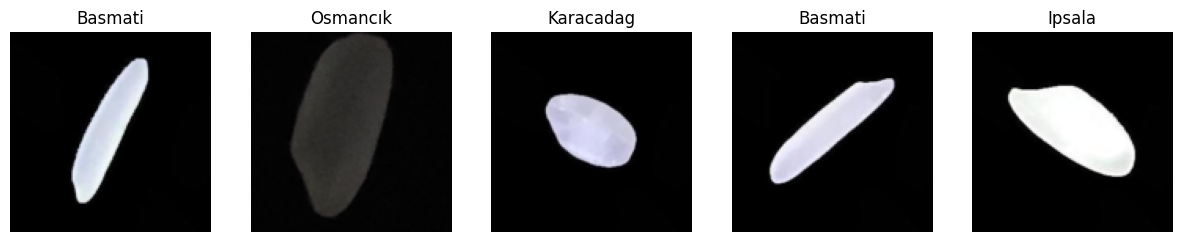


Samples From Test Dataset:


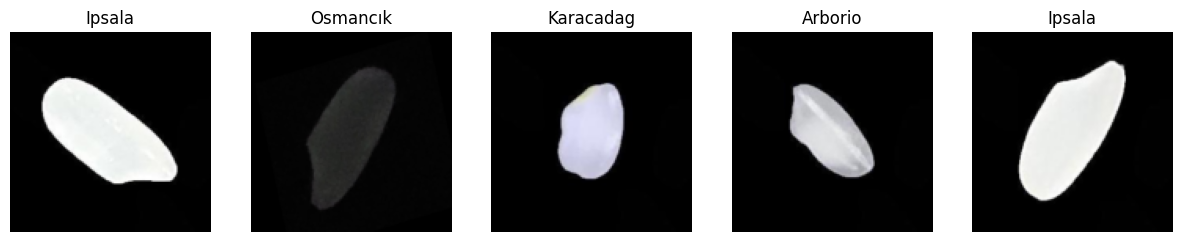

In [6]:
# Show random images from dataset
def show_images(dataloader, num_images=5):
    plt.figure(figsize=(15, 10)) 
    for images, labels in dataloader:
        for i in range(min(num_images, images.shape[0])):
            ax = plt.subplot(1, num_images, i + 1)
            image = images[i].permute(1, 2, 0).cpu().numpy() 
            image = (image * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5])
            image = image.clip(0, 1)
            plt.imshow(image)
            plt.title(class_names[labels[i]])
            plt.axis("off")
        plt.show()
        break

# Show sample images from train dataset
print("Samples From Train Dataset:")
show_images(dataloaders['train'])

# Show sample images from test dataset
print("\nSamples From Test Dataset:")
show_images(dataloaders['test'])

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [8]:
# CNN
class CNN(nn.Module) :
    def __init__(self) :
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # 3 channel input (RGB) 32 filters (feature map) 3x3 filter size padding preserves the size of the output
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # Activation that sets negative values ​​to 0
            nn.ReLU(),
            # 2x2 pooling, shifted by 2px during pooling
            # Reduce the input size by halving the feature maps and reduce computational cost
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        """
            - Calculating the size of the resulting image after Convolution and Pooling operations
            - Create a fake image from whatever image size you gave to CNN
            - For example, if you gave 128x128x3 or 32x32x3, create a dummy image accordingly.
        """
        
        # batch_size = 1, channels = 3, height = 128, weight = 128
        self.dummy_input = torch.randn(1, 3, 128, 128)
        # Give this dummy image to CNN
        dummy_output = self.conv_layers(self.dummy_input)
        # And find the output size
        print(dummy_output.shape) # [1, 128, 16, 16]
        print(dummy_output.shape[1] * dummy_output.shape[2] * dummy_output.shape[3]) # 128 * 16 * 16 = 32768
        
        # Fully connected layers
        self.dense_layers = nn.Sequential(
            # Flattened feature vector from convolution layers
            nn.Linear(128 * 16 * 16, 128), # 128 neuron
            nn.ReLU(), # Activation
            nn.Linear(128, 64), # Reduce output size to 64 neurons
            nn.ReLU(), # Activation
            nn.Dropout(p=0.3), # Disable random neurons. Prevent over-dependence of weights
            nn.Linear(64, 6) # Output of the model for 6 classes
        )
        
    def forward(self, X) :
        out = self.conv_layers(X) # Pass input data through convolution layers
        out = out.view(out.size(0), -1) # Flatten output for fully connected layer
        out = self.dense_layers(out) # Get the result by passing it through the fully connected layer
        return out


In [9]:
# Create CNN model
model = CNN()
model.to(device)

torch.Size([1, 128, 16, 16])
32768


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [10]:
# Hyperparameters for CNN
num_epochs = 10
learning_rate = 0.001

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
# weight_decay = L2 Regularization prevents overfitting by limiting the growth of weights. 
# Penalizes the model by keeping its weights small 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Variables to store train and test losses and accuracies
train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
test_accs = np.zeros(num_epochs)

# Start time to calculate how many seconds CNN takes
start_time = time.time()

# Training cycle
for epoch in range(num_epochs):
    # Set model state to training
    model.train()
    # Time to keep track of epochs
    t0 = time.time()
    # List for train losses
    train_loss = []
    # Number of all images and images known to be correct for accuracy calculation
    n_correct = 0
    n_total = 0

    for i, (images, labels) in enumerate(dataloaders["train"]):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() # Reset the gradients of the previous step
        loss.backward() # Calculate gradients
        optimizer.step() # Update model weights

        # Add train loss to list
        train_loss.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        # Accuracy calculation
        n_correct += (predicted == labels).sum().item()
        # Number of all labels
        n_total += labels.size(0)
        
    # Add training losses for this epoch to the list
    train_losses[epoch] = np.mean(train_loss)
    # Add training accuracy for this epoch to list
    train_accs[epoch] = n_correct / n_total

    # Set model state to evaluation
    model.eval() # Disables dropout layer
    # All predictions
    all_preds = []
    # All labels
    all_labels = []
    # All possibilities for ROC-AUC calculation
    all_probs = []
    # List to keep test losses
    test_loss = []
    # Number of correctly known images and all images for accuracy calculation
    n_correct = 0
    n_total = 0
    # Test phase without calculating gradient
    with torch.no_grad():
        for images, labels in dataloaders["test"]:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            
            # Possibilities for ROC-AUC
            probs = nn.functional.softmax(outputs, dim=1) # Convert model output to probabilities
            # Add possibilities to list
            all_probs.extend(probs.cpu().numpy())
            
            # Calculate the number of correctly predicted images
            n_correct += (predicted == labels).sum().item()
            # All labels
            n_total += labels.size(0)
            
            # Store all predictions and labels in lists for use in accuracy calculations
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Save test losses to list for each epoch
    test_losses[epoch] = np.mean(test_loss)
    # Save test verification to list for each epoch
    test_accs[epoch] = n_correct / n_total
    # End time of epoch
    end_time = time.time() - t0
    # Print accuracy, loss and duration for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Train Acc: {train_accs[epoch]:.4f}, Test Loss: {test_losses[epoch]:.4f}, Test Acc: {test_accs[epoch]:.4f}, Duration: {end_time:.2f}")

# CNN end time
finish_time_cnn = time.time() - start_time
# Print CNN's total time
print(f"Total duration for CNN is: {finish_time_cnn:.2f}")

Epoch [1/10], Train Loss: 1.5164, Train Acc: 0.3692, Test Loss: 0.7969, Test Acc: 0.7063, Duration: 2.45
Epoch [2/10], Train Loss: 0.7067, Train Acc: 0.7004, Test Loss: 0.4711, Test Acc: 0.7143, Duration: 1.60
Epoch [3/10], Train Loss: 0.4282, Train Acc: 0.8249, Test Loss: 0.2451, Test Acc: 0.8810, Duration: 1.49
Epoch [4/10], Train Loss: 0.2640, Train Acc: 0.8987, Test Loss: 0.1808, Test Acc: 0.9365, Duration: 1.48
Epoch [5/10], Train Loss: 0.2214, Train Acc: 0.9198, Test Loss: 0.1296, Test Acc: 0.9683, Duration: 1.53
Epoch [6/10], Train Loss: 0.1545, Train Acc: 0.9388, Test Loss: 0.0813, Test Acc: 0.9762, Duration: 1.56
Epoch [7/10], Train Loss: 0.1261, Train Acc: 0.9641, Test Loss: 0.0584, Test Acc: 0.9762, Duration: 1.49
Epoch [8/10], Train Loss: 0.1770, Train Acc: 0.9515, Test Loss: 0.1118, Test Acc: 0.9683, Duration: 1.52
Epoch [9/10], Train Loss: 0.0965, Train Acc: 0.9726, Test Loss: 0.1130, Test Acc: 0.9683, Duration: 1.50
Epoch [10/10], Train Loss: 0.0993, Train Acc: 0.9684, T

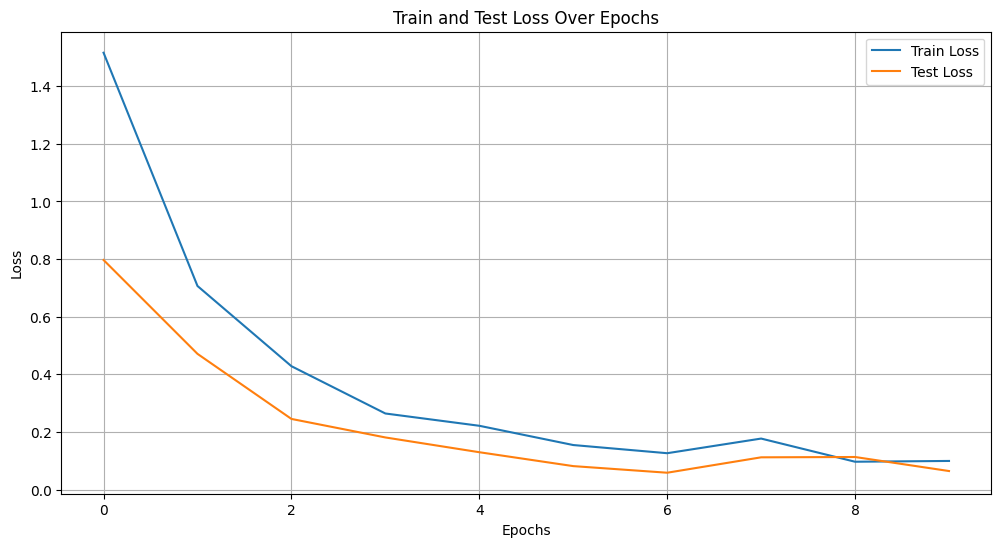

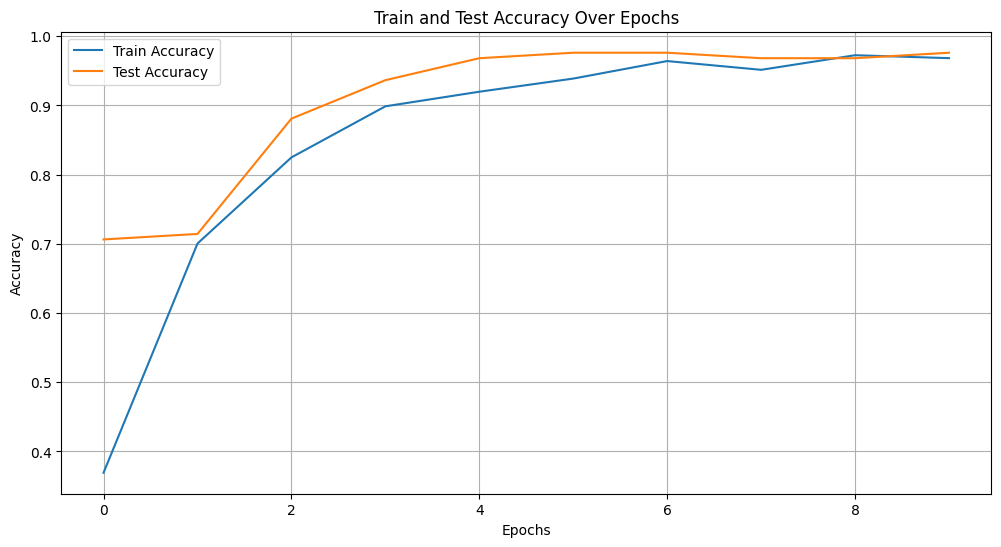

In [11]:
# Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.show()

# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

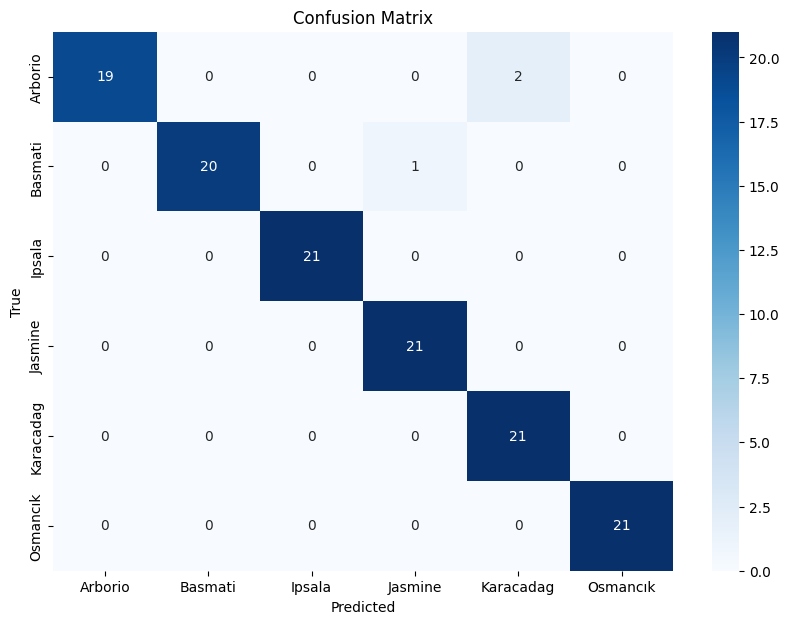

ROC-AUC Score: 0.9999
F1 Score: 0.9761
Classification Report:
               precision    recall  f1-score   support

     Arborio       1.00      0.90      0.95        21
     Basmati       1.00      0.95      0.98        21
      Ipsala       1.00      1.00      1.00        21
     Jasmine       0.95      1.00      0.98        21
   Karacadag       0.91      1.00      0.95        21
    Osmancık       1.00      1.00      1.00        21

    accuracy                           0.98       126
   macro avg       0.98      0.98      0.98       126
weighted avg       0.98      0.98      0.98       126



In [12]:
# Confusion Matrix
conf_matrix_cnn = confusion_matrix(all_labels, all_preds)

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=dataloaders['test'].dataset.classes, yticklabels=dataloaders['test'].dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print ROC-AUC Score
roc_auc_cnn = roc_auc_score(all_labels, all_probs, average="weighted", multi_class="ovr")
print(f"ROC-AUC Score: {roc_auc_cnn:.4f}")

# Calculate and print F1 Score
f1_cnn = f1_score(all_labels, all_preds, average="weighted")
print(f"F1 Score: {f1_cnn:.4f}")

# Print Detailed Classification Report
report_cnn = classification_report(all_labels, all_preds, target_names=dataloaders['test'].dataset.classes)
print("Classification Report:\n", report_cnn)

In [13]:
# Image preprocessing for random forest

# Empty lists for images and tags
train_images = []
train_labels = []
test_images = []
test_labels = []

# Add all images and labels from train dataset to lists
for i in image_datasets['train']:
    train_images.append(i[0])
    train_labels.append(i[1])

# Add all images and labels from test dataset to lists
for i in image_datasets['test']:
    test_images.append(i[0])
    test_labels.append(i[1])

# Convert images and labels to numpy arrays
images = np.concatenate((np.array(test_images), np.array(train_images)))
labels = np.concatenate((np.array(test_labels), np.array(train_labels)))

# Print total image information, image dimensions and number of tags
print(f"Number of All Images: {len(images)}")
print(f"Shapes of Images: {images.shape}")
print(f"Number of Labels: {labels.shape}")

Number of All Images: 600
Shapes of Images: (600, 3, 128, 128)
Number of Labels: (600,)


In [14]:
# Normalize the images between [0-1]
images = images / 255.0

In [15]:
# Feature extraction
# Convert images to a one-dimensional numpy array with dimensions weight * height
# This code is used to convert the image dataset into a feature vector
# The pixel intensity histogram of each image was used as the feature vector
# This process was done to prepare the input data to be used for the random forest
def extract_features(image):
    return np.histogram(image.ravel(), bins = 256, range=(0,256))[0]

features = np.array([extract_features(image) for image in images])

In [16]:
# Slit data as train and test
# Stratify is used to preserve class distribution while splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the sizes of training and test data
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

Train shape: (480, 256), Test shape: (120, 256)
Train labels shape: (480,), Test labels shape: (120,)


Random Forest Training Time: 0.06409096717834473
Accuracy: 0.68


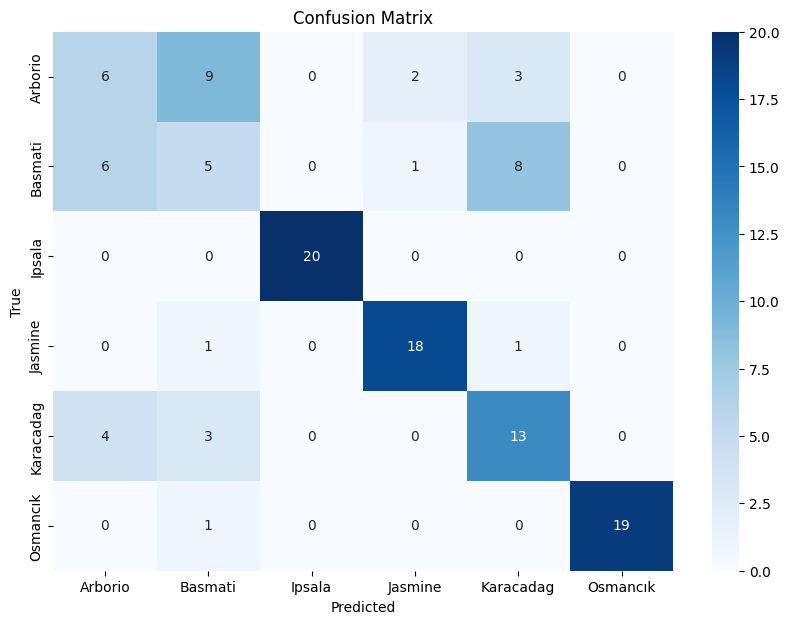

ROC-AUC Score: 0.8995
F1 Score: 0.6700
Classification Report:
              precision    recall  f1-score   support

     Arborio       0.38      0.30      0.33        20
     Basmati       0.26      0.25      0.26        20
      Ipsala       1.00      1.00      1.00        20
     Jasmine       0.86      0.90      0.88        20
   Karacadag       0.52      0.65      0.58        20
    Osmancık       1.00      0.95      0.97        20

    accuracy                           0.68       120
   macro avg       0.67      0.67      0.67       120
weighted avg       0.67      0.68      0.67       120



In [17]:
# Hyperparameters for Random Forest
estimators = 100
max_depth = 10
min_samples_split = 25

# Model
rf_model = RandomForestClassifier(n_estimators=estimators, max_depth=max_depth, min_samples_split=min_samples_split)
# Time for duration of training
start = time.time()

# Training the random forest model
rf_model.fit(X_train, y_train)
# Training time
train_time_forest = time.time() - start
print("Random Forest Training Time:", train_time_forest)  

# Model predictions
rf_preds = rf_model.predict(X_test)  

# Accuracy
accuracy_forest = accuracy_score(y_test, rf_preds)
print(f"Accuracy: {accuracy_forest:.2f}")

# Confusion Matrix
conf_matrix_forest = confusion_matrix(y_test, rf_preds)

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_forest, annot=True, fmt='d', cmap='Blues', xticklabels=dataloaders['test'].dataset.classes, yticklabels=dataloaders['test'].dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC - AUC Score 
y_prob = rf_model.predict_proba(X_test)
roc_auc_score_forest = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print(f"ROC-AUC Score: {roc_auc_score_forest:.4f}")

# Calculate F1 Score
f1_forest = f1_score(y_test, rf_preds, average="weighted")
print(f"F1 Score: {f1_forest:.4f}")
    
# Classification Report
classification_report_forest = classification_report(y_test, rf_preds, target_names=dataloaders['test'].dataset.classes)
print("Classification Report:")
print(classification_report_forest)

In [18]:
# Save models for later use

# Save CNN Model as pth
torch.save(model.state_dict(), "cnn_model.pth")

# Save Random Forest model as joblib
joblib.dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [19]:
# CNN results
cnn_results = {
    "ROC-AUC": roc_auc_cnn,  # ROC-AUC 
    "F1 Score": f1_cnn,  # F1 Score
    "Accuracy": test_accs[-1],   # Accuracy 
    "Durations (sec)": finish_time_cnn  # Durations
}

rf_results = {
    "ROC-AUC": roc_auc_score_forest,  
    "F1 Score": f1_forest,  
    "Accuracy": accuracy_forest,   
    "Durations (sec)": train_time_forest  
}

# DataFrame
df_results = pd.DataFrame([cnn_results, rf_results], index=["CNN", "Random Forest"])
display(df_results)

,ROC-AUC,F1 Score,Accuracy,Durations (sec)
CNN,0.999924,0.976150,0.97619,16.106541
Random Forest,0.899458,0.669988,0.67500,0.064091


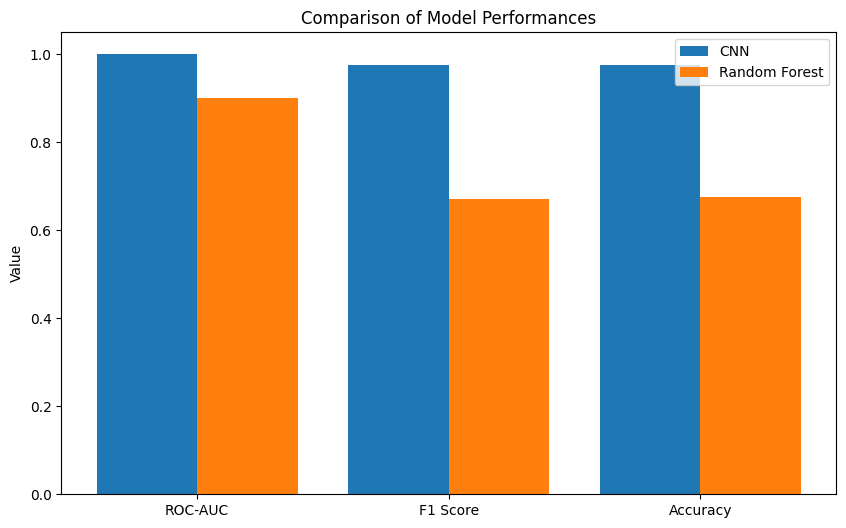

In [20]:
# Performance metrics
metrics = ["ROC-AUC", "F1 Score", "Accuracy"]
cnn_values = [roc_auc_cnn, f1_cnn, test_accs[-1]]
rf_values = [roc_auc_score_forest, f1_forest, accuracy_forest]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, cnn_values, width=0.4, label="CNN", align="center")
plt.bar([i + 0.4 for i in x], rf_values, width=0.4, label="Random Forest", align="center")
plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel("Value")
plt.title("Comparison of Model Performances")
plt.legend()
plt.show()